# Classification
$$
\renewcommand{\like}{{\cal L}}
\renewcommand{\loglike}{{\ell}}
\renewcommand{\err}{{\cal E}}
\renewcommand{\dat}{{\cal D}}
\renewcommand{\hyp}{{\cal H}}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{{\mathbf x}}
\renewcommand{\v}[1]{{\mathbf #1}}
$$

**Note:** We've adapted this Mini Project from [Lab 5 in the CS109](https://github.com/cs109/2015lab5) course. Please feel free to check out the original lab, both for more exercises, as well as solutions.

We turn our attention to **classification**. Classification tries to predict, which of a small set of classes, an observation belongs to. Mathematically, the aim is to find $y$, a **label** based on knowing a feature vector $\x$. For instance, consider predicting gender from seeing a person's face, something we do fairly well as humans. To have a machine do this well, we would typically feed the machine a bunch of images of people which have been labelled "male" or "female" (the training set), and have it learn the gender of the person in the image from the labels and the *features* used to determine gender. Then, given a new photo, the trained algorithm returns us the gender of the person in the photo.

There are different ways of making classifications. One idea is shown schematically in the image below, where we find a line that divides "things" of two different types in a 2-dimensional feature space. The classification show in the figure below is an example of a maximum-margin classifier where construct a decision boundary that is far as possible away from both classes of points. The fact that a line can be drawn to separate the two classes makes the problem *linearly separable*. Support Vector Machines (SVM) are an example of a maximum-margin classifier.

![Splitting using a single line](images/onelinesplit.png)



In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn.model_selection

c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, 
                cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, 
               s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, 
               alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, 
                     cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, 
                           colorscale=colorscale, cdiscrete=cdiscrete, 
                           psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

## A Motivating Example Using `sklearn`: Heights and Weights

We'll use a dataset of heights and weights of males and females to hone our understanding of classifiers. We load the data into a dataframe and plot it.

In [2]:
dflog = pd.read_csv("data/01_heights_weights_genders.csv")
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


Remember that the form of data we will use always is

![dataform](images/data.png)

with the "response" or "label" $y$ as a plain array of 0s and 1s for binary classification. Sometimes we will also see -1 and +1 instead. There are also *multiclass* classifiers that can assign an observation to one of $K > 2$ classes and the labe may then be an integer, but we will not be discussing those here.

`y = [1,1,0,0,0,1,0,1,0....]`.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<ul>
  <li> <b>Exercise:</b> Create a scatter plot of Weight vs. Height
  <li> <b>Exercise:</b> Color the points differently by Gender
</ul>
</div>

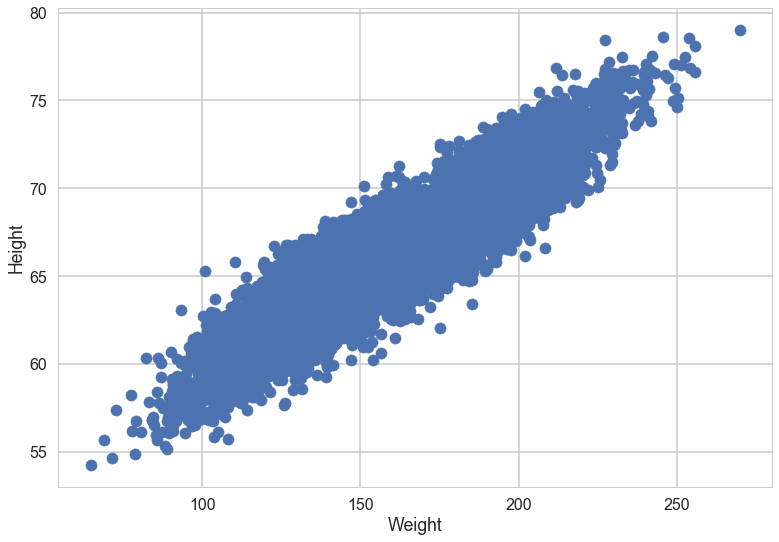

In [3]:
# your turn
plt.scatter(dflog.Weight, dflog.Height)
plt.xlabel('Weight')
plt.ylabel('Height')

### Training and Test Datasets

When fitting models, we would like to ensure two things:

* We have found the best model (in terms of model parameters).
* The model is highly likely to generalize i.e. perform well on unseen data.

<br/>
<div class="span5 alert alert-success">
<h4>Purpose of splitting data into Training/testing sets</h4>
<ul>
  <li> We built our model with the requirement that the model fit the data well. </li>
  <li> As a side-effect, the model will fit <b>THIS</b> dataset well. What about new data? </li>
    <ul>
      <li> We wanted the model for predictions, right?</li>
    </ul>
  <li> One simple solution, leave out some data (for <b>testing</b>) and <b>train</b> the model on the rest </li>
  <li> This also leads directly to the idea of cross-validation, next section. </li>  
</ul>
</div>

First, we try a basic Logistic Regression:

* Split the data into a training and test (hold-out) set
* Train on the training set, and test for accuracy on the testing set

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['Height','Weight']].values, 
                                              (dflog.Gender == "Male").values,random_state=5)

clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(Xlr, ylr)
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

0.9252


### Tuning the Model

The model has some hyperparameters we can tune for hopefully better performance. For tuning the parameters of your model, you will use a mix of *cross-validation* and *grid search*. In Logistic Regression, the most important parameter to tune is the *regularization parameter* `C`. Note that the regularization parameter is not always part of the logistic regression model. 

The regularization parameter is used to control for unlikely high regression coefficients, and in other cases can be used when data is sparse, as a method of feature selection.

You will now implement some code to perform model tuning and selecting the regularization parameter $C$.

We use the following `cv_score` function to perform K-fold cross-validation and apply a scoring function to each test fold. In this incarnation we use accuracy score as the default scoring function.

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

Below is an example of using the `cv_score` function for a basic logistic regression model without regularization.

In [6]:
clf = LogisticRegression()
score = cv_score(clf, Xlr, ylr)
print(score)

0.917066666667


<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<b>Exercise:</b> Implement the following search procedure to find a good model
<ul>
<li> You are given a list of possible values of `C` below
<li> For each C:
  <ol>
  <li> Create a logistic regression model with that value of C
  <li> Find the average score for this model using the `cv_score` function **only on the training set** `(Xlr, ylr)`
  </ol>
<li> Pick the C with the highest average score
</ul>
Your goal is to find the best model parameters based *only* on the training set, without showing the model test set at all (which is why the test set is also called a *hold-out* set).
</div>

In [7]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

# your turn
max_score = 0
best_c = 0

for c in Cs:
    clf = LogisticRegression(C=c)
    score_c = cv_score(clf, Xlr, ylr)
    if score_c > max_score:
        max_score = score_c
        best_c = c
        
print('Best C:', best_c)
print('Best Accuracy:', max_score)

Best C: 0.1
Best Accuracy: 0.917066666667


<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>
**Exercise:** Now you want to estimate how this model will predict on unseen data in the following way:
<ol>
<li> Use the C you obtained from the procedure earlier and train a Logistic Regression on the training data
<li> Calculate the accuracy on the test data
</ol>

<p>You may notice that this particular value of `C` may or may not do as well as simply running the default model on a random train-test split. </p>

<ul>
<li> Do you think that's a problem? 
<li> Why do we need to do this whole cross-validation and grid search stuff anyway?
</ul>

</div>

In [8]:
# your turn
clf = LogisticRegression(C=best_c)
clf.fit(Xlr, ylr)
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

0.9252


### Black Box Grid Search in `sklearn`

Scikit-learn, as with many other Python packages, provides utilities to perform common operations so you do not have to do it manually. It is important to understand the mechanics of each operation, but at a certain point, you will want to use the utility instead to save time...

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<b>Exercise:</b> Use scikit-learn's [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) tool to perform cross validation and grid search. 

* Instead of writing your own loops above to iterate over the model parameters, can you use GridSearchCV to find the best model over the training set? 
* Does it give you the same best value of `C`?
* How does this model you've obtained perform on the test set?

In [9]:
# your turn

parameters = {'C':[0.001, 0.1, 1, 10, 100]}
LR = LogisticRegression()
clf = sklearn.model_selection.GridSearchCV(LR, parameters, cv=5)
clf.fit(Xlr, ylr)

print('Best Model:', clf.best_estimator_)
print('Best C:', clf.best_params_)
print('Best Accuracy on Training Set:', clf.best_score_)

clf.fit(Xlr, ylr)
print('Accuracy on Test Set', accuracy_score(clf.predict(Xtestlr), ytestlr))


Best Model: LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best C: {'C': 0.001}
Best Accuracy on Training Set: 0.9172
Accuracy on Test Set 0.9256
